In [7]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from keras.utils import model_to_dot
from keras import backend as K
from IPython.display import SVG
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

img_width, img_height = 255, 255

if K.image_data_format() == 'channels_first':
    shape = (3, img_width, img_height)
else:
    shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
predict_datagen = ImageDataGenerator()

In [10]:
train_data_dir = './dataset/train_set'
validation_data_dir = './dataset/validation_set'
predict_data_dir = './dataset/predict_set'
epochs = 5
batch_size = 64

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

prediction_generator = predict_datagen.flow_from_directory(
    predict_data_dir,
    target_size=(img_width, img_height),
    shuffle=False,
    class_mode='binary')

Found 6266 images belonging to 2 classes.
Found 1302 images belonging to 2 classes.
Found 1 images belonging to 2 classes.


### Training Model

In [31]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=6266 // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=1302 // batch_size
)
history

Epoch 1/5
97/97 [==============================] - 36s 375ms/step - loss: 0.2049 - accuracy: 0.9241 - val_loss: 0.1921 - val_accuracy: 0.9445
Epoch 2/5
97/97 [==============================] - 42s 434ms/step - loss: 0.1793 - accuracy: 0.9368 - val_loss: 0.1434 - val_accuracy: 0.9216
Epoch 3/5
97/97 [==============================] - 42s 434ms/step - loss: 0.1683 - accuracy: 0.9326 - val_loss: 0.1543 - val_accuracy: 0.9475
Epoch 4/5
97/97 [==============================] - 43s 448ms/step - loss: 0.1392 - accuracy: 0.9471 - val_loss: 0.2831 - val_accuracy: 0.9015
Epoch 5/5
97/97 [==============================] - 42s 436ms/step - loss: 0.1425 - accuracy: 0.9494 - val_loss: 0.2111 - val_accuracy: 0.9006


In [33]:
test_data_dir = './dataset/test_set'
test_it = test_datagen.flow_from_directory(
    test_data_dir, 
    target_size=(img_width, img_height), 
    class_mode='binary', 
    batch_size=batch_size
)
result = model.evaluate_generator(test_it, steps=32)
print('loss:', result[0], 'accuracy:', result[1])

Found 1299 images belonging to 2 classes.
loss: 0.37254059314727783 accuracy: 0.898152768611908


### Model Prediction

In [34]:
classification_index = train_generator.class_indices
print(classification_index)

predict_outcome = model.predict(prediction_generator)
df = pd.DataFrame(data=predict_outcome, index=['nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'sfw', 'sfw', 'sfw', 'sfw', 'sfw', 'sfw' ], columns=['Predicted Label'])
df

{'nsfw': 0, 'sfw': 1}


,Predicted Label
nsfw,0.0
nsfw,0.0
nsfw,1.0
nsfw,0.0
nsfw,1.0
nsfw,0.0
nsfw,0.0
nsfw,0.0
nsfw,1.0
nsfw,0.0


### Model Prediction - Single Item

In [19]:
img = load_img(predict_data_dir + '/sfw/4.jpg', target_size=(img_width, img_height))
data = img_to_array(img)
data = data.reshape((1,) + data.shape)
pred = model.predict(data)
df = pd.DataFrame(data=predict, columns=['Predicted Label'])
df

NameError: name 'predict' is not defined

### Saving Model

In [8]:
model.save("./model/model_5_64batch_5epochs.h5")

### Loading Model

In [5]:
model_name = 'model_5_64batch_5epochs' + '.h5'

loaded_model = load_model("./model/" + model_name)

test_data_dir = './dataset/test_set'
test_it = test_datagen.flow_from_directory(
    test_data_dir, 
    target_size=(img_width, img_height), 
    class_mode='binary', 
    batch_size=batch_size
)
loaded_result = loaded_model.evaluate_generator(test_it, steps=32)
print('loss:', loaded_result[0], 'accuracy:', loaded_result[1])

Found 1299 images belonging to 2 classes.
loss: 0.16858892142772675 accuracy: 0.9001497626304626


In [13]:
classification_index = train_generator.class_indices
print(classification_index)

predict_outcome = loaded_model.predict_generator(prediction_generator)
df = pd.DataFrame(data=predict_outcome, index=['nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'nsfw', 'sfw', 'sfw', 'sfw', 'sfw', 'sfw', 'sfw' ], columns=['Predicted Label'])
df

{'nsfw': 0, 'sfw': 1}


,Predicted Label
nsfw,0.0
nsfw,0.0
nsfw,1.0
nsfw,0.0
nsfw,1.0
nsfw,0.0
nsfw,0.0
nsfw,0.0
nsfw,0.0
nsfw,0.0


### Single Image Prediction

In [11]:
import urllib.request as request

url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAPEA8PEA8PDw8PDw8PDw8NDw8NDw8PFREWFhUVFRUYHSggGBolGxUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQFS0dHSYrKysrLS0vNysrLS0rKy0rKystOCstLSstKysrLSstLS0tLSstLS0rLS0tKystLSstLf/AABEIAQkAvgMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAABAgMEBQAGB//EAD0QAAIBAgMFBgQDBgUFAAAAAAABAgMRBBIhBRMxQVEGImFxgaEykbHBQlLhFCNygtHwFWKSssIWM0OD8f/EABkBAQEBAQEBAAAAAAAAAAAAAAABBAMCBf/EACMRAQADAAEEAgIDAAAAAAAAAAABAhEDEiExMgQiQaETUWH/2gAMAwEAAhEDEQA/APmJxyGPCuCgIIUQoAyAKGQEMADgnACx1ghACQTkEihY6wQ2CEOsNYBQljhrAsVCgYwAFANYDQEaCEJFAIbBSAAyOsMkByCckFIDjhrFepioqWRXlN/hX36EVMEuYHY1arHM3JJq6yQ+75eJmYuFbDyaqxcoX42s/wBTzFomcep47RG4nCdTakk1qmrp9UNY9PJQhsGwCAHsdYIjAPYFihAMdoDRUIBj2BYCOwyRyQyRFBIZIKQUgBYNgpBSIoJDWOSDYAWLewdmRq4mMHopuM5PjmSTuiCnG7S6tL3HxeKeFrwqw/Co2X5orRr1+xzvP4deKPzL6ntZxoYZ5IJuKSiuSu7XfguJ5ihgp4mnXnWpONO9qWe2apG2srcuRP2fr1MVVWIhNvDOEnJynmc5tWVNRvaKj5X8Sz/iNSKqRqRajKdqNN/HGGa0pS6Ru0l15Gfw2RGvDYqMKccr7ss8YQXWNmrey9yKxpdpMOr6RvKElNLmZ1NppNcHqaeOdhj5oywWOsPY6x0cSWBYex1gI2gND2BYCNoVolaFaKiNoFiSwtgESDYIUiK5IKRwUiK6wUgpBsAEg2DYKQQ1Jd5eaD2joxlwllcIJu/eavwTfWy+bOho0y12hwlNU6OrzzcpT8YuPP2OXJ5h34vEwrdl8ZUwd3Btxm7yjfRu1rrxPUf4zQlJVZJuas0pN2zpd1tc7Hm9n7LryinCE5X00j3X68Lnp9k9mWu9WV5fkTVorx6s8X6c38unHa8TkeGFtHE55OTd3J3Zm0U7tRV10XI9viuzkJJpd3hy046kNHYEKNnHvSvz0SPNb4634+p5Vwa4przTQLH0+lg6eVeXrc8T2moRhV7vXXxOleXZyYcLcGRsSxbHWHsCx2Z0dgWJGgNBETQGiRoVoojsCw7QGioiSCcgnl6cMkckEAhOOCCFI5IZASYaKc45vhur8rroekwVKOLxUIuC3NKOaUUr5uSi30vr8zzKPbdnGlCUoqzcIqd/izJX18PA4c39tPB5xtVqEVe0Ulx5aEcY+LuHA0alSDck1x489TPx1Z03xM8tkNZ03ZNtmfjJJGhhW6sadvyop7bwqhTlO6ur6eg8prGwW13Os6UdVaUvRf8A0ye0jvO/O6Idm4mNPFQq8I1adSlZ8pNxkv8Aaw7bvmv1ase4jJhJ7xKjYFh7AsbXzCNCtEjQrQEbQrRK0K0BG0LYkaFaCIBkBBRHoUFHBCOGQAoAodICGRFPRm4tSjo1wfR9Uew7KQy4epUfOpJ687WX9Tx6R7PDvc4CK5yg5P11+5y5fDR8eNs1a/aKlTp6SjZ9Ob6GVDDuSlia6av/ANmk9H/FJdei+fhW7L4KG5p13CLnLM87Sbs5NrXyNHa+IukvRIzzLXEYn/bf2ZU3buuCzW4p8bmftLaaqp5WpJ9CxtWayWfHKjx2KWrlfXwLBMKm1qy3kIxfeg1N25cUvuT4iq52vxuitsnZ0q9aUvzcF/li7fW5ar08tTL+W50z7RDlM5WZCwLD2BY0sBLAaHaFaKEaFaJGhWgI2hWiRiNAVkMhUMiKIQIZBBQyFQ6Cih0hUOiCfB4d1akKa4zko+XV/I9ZtyjKVN0aS/LTh0vaxndj6F6s6j/8cNPOX6J/M9VgaKd5vq7f1M/LPfGz49crqHB4Lc0adKP4IRivGytcrV8MlJN6ta2NiTS4mXK7qVKjlFQSSil8Unre76cDi7xLF2tUb4vgebxU7tpcZOyPQ1f3k5dDDxtPJVi+TvH1f9+57p5wvOVmYbvZXDKEatd8KcN3Hz4v7fMwZzz1Kk+rPUT/AHOBhHnUWd/za/Sx5ektL9Xc6173mWa/14og1gDAO7KVisdigIxWO0BoqI2KyRiMCmMhUMiKZBQEMggodCoZEUyJEJFDoI9T2a7mHq1PzTsvRI9K5ZYRS5pW8rHmsypwwuG5ycZT833ma9WGVcX4eRktO2fSrXKxCXEVdOJlYio9UWZtyWhRrwkuR5eolWhO10lqzE2xJ56cUtXVpRXm5pfc9BhaN2378kU8LT32Npuy3eFjKtLpKa0hfxu7/wApY8k9+y52nq5VGkvwxjH5KxgpF3asnKd3xevzKdjRxR21k+Rb7YABgHVnKxRmBoBWKx2hWioRiMkYjQFBDoRDIinQyFQyCGQyFQyIqSJYwVLPUpw/NOKflfUrRNTYbjGVStLhQpSqJc27WJach6pXbRD0FTAN46E5WcVTc425Sso/Rv5l3aj4+BS2ftB16qnbu/s1Gcf/AGXb/wBqG2jV1Zkny+liLD4+KTUtGUsZjc3CXPlxMPbdSSTytrnoSbLwjnWppybUpaq1r9T1FdjXi1orOS9RgqbnTWVZYdX+JkqwcKFGcvx1dZPm7cF5I0aslGKjHRRXI8/tHGStKOjSVOMfOV3L2R5e47MatK8mIJGpm19fnqMa6eIfO5feXACBnt4BisZikAYrGYrKhWKxmIwKCGQqGRFMhkKhkVDIdCIZEVJEubPmlJxl8NSE6Tvw7ysvexTiOiTGrWcnW/2SlLdPOrSp2w7tz3V1f1uiTaNXUXYk/wB03zc5N+L0INoS4sx29pfUrO1iYZO0ZZnbq7FvZ9bJUhLpL66fcz4PNNvovdlg0Ur9WLmv94/x7WnVueW2lOcJyjJPVzndJ5btZVZ+Rs7Kr5oK/FaP0INrO6dzP4nGyO8a87h3rL0+n6E5DS+KXp9yU109Xz+X3kQM4B7cwYAsUgDFYzFZUKxQsDCKCGQqGRHoyGQqGRUMMhUOiKaJIiNDoo3tgtOEk+Um/ZFHbWJjFPVdOJUjsSVWEqixNSindZYrMnZfxIwXsmTb/ftpN6uPH3OP8dJts3/TZXk5IpERT9rmG2hSinnmlJy1Vm3blwRcp4+lLhUj6vL9TAxGyqkLPNeL+KS0y+LXTxK1SCWSNKo6lVtKVPI+768Hqa446Z5YLXtMzOPdbK2pTg2nUhbj8SJNp7VotO1WD8pJnncLseOVbyUnNrVQyqKl4aEn/TSmnarKLtomlL58DPenD1d7S18XJyzXIrErGDxEJuWSSlbLezva9y2ZuycFGg6kU3JvLq0lwvoaJYyI+vhyv1dX28uAdcFyvDmKzmwNhHNis5itlHMRhbFbKikhkOqYypkxdKgodUxlTARDodUxlTARDoZUybD0M0orrJfInhYjZxcqvLTjG+Xu6+fMy6NOyb6s3cdQjq2rmVa7aXIzU7y+jyz007EQIxS4JK/GySuTbsKpGp80kZWafRmzUglHNDnHR+Blbo0cHrTcHy4eTOPLXtrV8a+W6WDmaqPza/v5Fm4uMwrT8np9SWMbpPqrl452MT5NctqNsVsndMV0jqzIGwXJXSBugiK4rJt2BwKIGxWyZwEcAHVIZUi8qJJGiBQVEdUS+qJIqAGcqIyoGkqA24AzlQLGDpWnF9C2sONu8tn5/Q8X9ZdOL3hFiXe78WZ+Fp3c34pe36lzEStEmwWGtBPnLvfPh7WOHDHdq+Rb64q7kKomjuA7k0sLO3JZwULOS6osbk6MLanm8bWXTinLwo4ulxfgyrg6d4LwbXybNDFcSDZdO8Z+FSS9kzjw+Wn5PqTcg3Jo7kV0jSxM90RHRNCVIilACi6RG6ZflEhlECm4COBZmiKTA2VhyRUDQVAZUwKCokkaJdVMdUgKSoBVEuqkPukBRVEgxkbW9TWVIzdtvKo+Uv8AijnyesuvD7wyVT3lSMOTd35cWbu5KHZujmdSq/4I/V/Y3t0TijIeue22xS3Ryol3dA3R1cVJ0gbrwL27EkiDBxVNptdPcTYC1rp8pxdvNP8AoaO0YrR9dH9vuZmzJ5atdfwf8jhWMvjXeeri1qtIhqWI54grVa/id2RPOSK9SZWqYkrzxLAszmiGVRFWdVkMpNgWp1EV51UR5ZM7cMD6FuwqmW1TG3ZUVd2HdltUgqkBVVIKpFvdBVLwb8AIaGGzc7Gb2n2OpU1KEpbxZXu5WtKKb7vDR68/Dgb9K0O/LuuPBad2+l/Mxdo45N3b9+JbViYyVraazsIOzdDLh4J8c02+WudmqonnKG3JxbpUqLrNyck4vuq/Jlp0MfW1ahRX+pnmOyzOzrVqVYR4tFKvtSmuaK8OzM5a1K8peTsi1R7OUo8r+YRSntVPhqQvEylyZvw2XTj+EmWEgvwoDzVGhOrKMLPvNLy8R9odn93PeQnd2UailomrLg+qbXTieow9JRkpJLQOJorvPi5R5ctW2+HP7CKRM6vXMRjxksI+JVq0EjS2lVlTapqDk3fK1azXmQUtk1qustF0QRlTghVQbPT0NgJcS1HZcUB5FYNvkSR2e+h61YKK5B/ZY9Ajy0dneBItneB6VYddDtwijSUQ5Rkhrf2wpVEKiMMkAuUjxW9jG9GNOc7/AA1JummufeSdn6E6iMkBhuji6j71GnTv1xCnH2jf2HpdnKbeatJ1XyhFOFOPpxfmbiQbAQUcPCCtCEYL/KkiTKPY4BMvgBxHZwEeQKghwANBJGbtTblHCp71Vl0cMNXrxf8ANCLXzZoAbCPB4rbFLFVI7lVZyU1ZOjVpq3Pikevo0rRWltCyK0BC4iuJKxWgIXEVxJmhGgInEVolaFA0IPSxZWJV23G7bbTfJNrTy09yohwLTrJJWSdklb/Te/Tg1p1ZHUqXd7W+/mRBQEil9b/oBsAwVyCccgBYNjggCwLDHAKCwwAFYGFgAjaFJGIwEYrHYjCEYrHYjAVisaQrA//Z"

request.urlretrieve(url, predict_data_dir + '/nsfw/test.jpg')

('./dataset/predict_set/nsfw/test.jpg',
 <email.message.Message at 0x2ebc5097bc8>)

In [13]:
file_name = '/sfw/test.jpg'

img = load_img(predict_data_dir + file_name, target_size=(img_width, img_height))
data = img_to_array(img)
data = data.reshape((1,) + data.shape)
pred = loaded_model.predict(data)

classification_index = {0: "nsfw", 1: "sfw"}
print(classification_index)
df = pd.DataFrame(data=classification_index[int(pred[0][0])], columns=['Predicted Label'], index=[file_name])
df

{0: 'nsfw', 1: 'sfw'}


,Predicted Label
/sfw/test.jpg,sfw


### Data Visualization

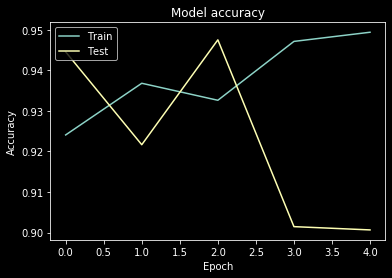

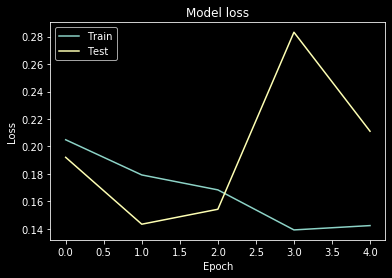

In [32]:
# SVG(model_to_dot(loaded_model).create(prog='dot', format='svg'))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()